In [ ]:
import os
import sys
import time
import shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from PIL import Image

# ==============================================================================
# 1. CẤU HÌNH HỆ THỐNG (CONFIG)
# ==============================================================================
# ⚠️ QUAN TRỌNG: Sửa đường dẫn này trỏ đúng vào thư mục train của RAF-DB trên Kaggle của bạn
DATASET_PATH = "/kaggle/input/raf-db-dataset/DATASET/train" 

BATCH_SIZE = 16
IMAGE_SIZE = 128
C_DIM = 3            # 3 cảm xúc: Neutral, Happy, Sad
START_EPOCH = 0      # Bắt đầu từ 0
END_EPOCH = 50       # Chạy đến 50 (để nối tiếp với notebook kia)
LR = 1e-4            # Learning Rate
BETA1 = 0.5
BETA2 = 0.999

# Tạo các thư mục lưu trữ kết quả
CHECKPOINT_DIR = "/kaggle/working/checkpoints_epoch_0_to_50"
SAMPLE_DIR = "/kaggle/working/samples_epoch_0_to_50"
if not os.path.exists(CHECKPOINT_DIR): os.makedirs(CHECKPOINT_DIR)
if not os.path.exists(SAMPLE_DIR): os.makedirs(SAMPLE_DIR)

print(f"🚀 Cấu hình: Batch {BATCH_SIZE} | Img {IMAGE_SIZE} | Epoch {START_EPOCH}-{END_EPOCH}")
print(f"📂 Dataset: {DATASET_PATH}")

# ==============================================================================
# 2. XÂY DỰNG DATA LOADER (CÓ OVERSAMPLING CHO LỚP SAD)
# ==============================================================================
def load_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    img = (img / 127.5) - 1.0  # Normalize về [-1, 1]
    return img, label

def get_dataset(dataset_path, batch_size=16):
    # Mapping folder name sang label id (Sửa nếu dataset của bạn khác tên folder)
    # Ví dụ: RAF-DB thường là: 7 (Neutral), 4 (Happy), 5 (Sad)
    # Map về: 0 (Neutral), 1 (Happy), 2 (Sad)
    folder_map = {'7': 0, '4': 1, '5': 2} 
    
    all_datasets = []
    
    print("🔄 Đang load dữ liệu...")
    for folder_name, label_id in folder_map.items():
        search_path = os.path.join(dataset_path, folder_name, "*")
        files_ds = tf.data.Dataset.list_files(search_path, shuffle=True)
        
        # === OVERSAMPLING STRATEGY (QUAN TRỌNG) ===
        # Nếu là class Sad (ID=2), nhân bản dữ liệu lên 8 lần
        if label_id == 2:
            print(f"🔥 Phát hiện class SAD (ID=2): Kích hoạt Oversampling (x8 lần)!")
            files_ds = files_ds.repeat(8)
        # ===========================================
        
        # Check xem có tìm thấy file không
        num_files = len(list(files_ds.take(10000))) # Count sơ bộ
        print(f"   -> Class {label_id} (Folder {folder_name}): ~{num_files} ảnh")

        if num_files == 0:
            print(f"⚠️ CẢNH BÁO: Không tìm thấy ảnh trong folder {folder_name}. Kiểm tra lại path!")
            continue

        labeled_ds = files_ds.map(lambda x: load_image(x, label_id), num_parallel_calls=tf.data.AUTOTUNE)
        all_datasets.append(labeled_ds)
    
    if not all_datasets:
        raise ValueError("❌ Không load được dataset nào cả! Hãy kiểm tra lại DATASET_PATH.")

    # Gộp tất cả lại
    dataset = all_datasets[0]
    for ds in all_datasets[1:]:
        dataset = dataset.concatenate(ds)
    
    dataset = dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# ==============================================================================
# 3. ĐỊNH NGHĨA MODEL (InstanceNorm, ResBlock, Generator, Discriminator)
# ==============================================================================
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(name='scale', shape=input_shape[-1:], initializer=tf.random_normal_initializer(1., 0.02), trainable=True)
        self.offset = self.add_weight(name='offset', shape=input_shape[-1:], initializer='zeros', trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        return self.scale * ((x - mean) * tf.math.rsqrt(variance + self.epsilon)) + self.offset

def res_block(x, filters):
    res = x
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x)
    return layers.add([res, x])

def build_generator(c_dim=3):
    img_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    label_input = Input(shape=(c_dim,))
    
    # Ghép Label vào ảnh
    label_layer = layers.RepeatVector(IMAGE_SIZE * IMAGE_SIZE)(label_input)
    label_layer = layers.Reshape((IMAGE_SIZE, IMAGE_SIZE, c_dim))(label_layer)
    x = layers.concatenate([img_input, label_layer])
    
    # Down-sampling
    x = layers.Conv2D(64, 7, strides=1, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x); x = layers.ReLU()(x)
    
    x = layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x); x = layers.ReLU()(x)
    
    x = layers.Conv2D(256, 4, strides=2, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x); x = layers.ReLU()(x)
    
    # Bottleneck (6 ResBlocks)
    for _ in range(6):
        x = res_block(x, 256)
        
    # Up-sampling
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x); x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x); x = layers.ReLU()(x)
    
    x = layers.Conv2D(3, 7, strides=1, padding='same', use_bias=False)(x)
    output = layers.Activation('tanh')(x) # Output [-1, 1]
    
    return Model([img_input, label_input], output, name="Generator")

def build_discriminator(c_dim=3):
    img_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    x = layers.Conv2D(64, 4, strides=2, padding='same')(img_input)
    x = layers.LeakyReLU(0.01)(x)
    
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.01)(x)
    
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.01)(x)
    
    x = layers.Conv2D(512, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.01)(x)
    
    x = layers.Conv2D(1024, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.01)(x)
    
    # Output 1: Real/Fake (PatchGAN)
    out_src = layers.Conv2D(1, 3, strides=1, padding='same')(x)
    
    # Output 2: Domain Classification
    k_size = int(IMAGE_SIZE / 32)
    out_cls = layers.Conv2D(c_dim, k_size, strides=1, padding='valid')(x)
    out_cls = layers.Flatten()(out_cls)
    
    return Model(img_input, [out_src, out_cls], name="Discriminator")

# ==============================================================================
# 4. KHỞI TẠO VÀ TRAINING LOOP
# ==============================================================================

# Khởi tạo
generator = build_generator(C_DIM)
discriminator = build_discriminator(C_DIM)
g_optimizer = tf.keras.optimizers.Adam(LR, beta_1=BETA1, beta_2=BETA2)
d_optimizer = tf.keras.optimizers.Adam(LR, beta_1=BETA1, beta_2=BETA2)

# Load Data
dataset = get_dataset(DATASET_PATH, BATCH_SIZE)

# Loss functions
mse_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

@tf.function
def train_step(real_img, real_label_idx):
    # Tạo nhãn đích ngẫu nhiên
    batch_size = tf.shape(real_img)[0]
    
    # One-hot encoding
    real_label = tf.one_hot(real_label_idx, C_DIM)
    
    # Random target label
    rand_idx = tf.random.uniform(shape=[batch_size], minval=0, maxval=C_DIM, dtype=tf.int32)
    target_label = tf.one_hot(rand_idx, C_DIM)
    
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        # --- Forward Pass ---
        fake_img = generator([real_img, target_label], training=True)     # Ảnh giả (từ gốc -> target)
        rec_img = generator([fake_img, real_label], training=True)        # Ảnh phục hồi (từ giả -> gốc)
        
        # Discriminator on Real
        d_real_src, d_real_cls = discriminator(real_img, training=True)
        # Discriminator on Fake
        d_fake_src, d_fake_cls = discriminator(fake_img, training=True)
        
        # --- Discriminator Loss ---
        # 1. Adv Loss: Real phải là 1, Fake phải là 0
        d_loss_real = mse_loss(tf.ones_like(d_real_src), d_real_src)
        d_loss_fake = mse_loss(tf.zeros_like(d_fake_src), d_fake_src)
        # 2. Domain Class Loss: Phải phân loại đúng ảnh thật
        d_loss_cls = cce_loss(real_label, d_real_cls)
        
        d_loss = d_loss_real + d_loss_fake + d_loss_cls
        
        # --- Generator Loss ---
        # 1. Adv Loss: Fake phải lừa được D (tiến về 1)
        g_loss_fake = mse_loss(tf.ones_like(d_fake_src), d_fake_src)
        # 2. Domain Class Loss: Fake phải được phân loại đúng nhãn target
        g_loss_cls = cce_loss(target_label, d_fake_cls)
        # 3. Reconstruction Loss: Ảnh phục hồi phải giống ảnh gốc
        g_loss_rec = l1_loss(real_img, rec_img)
        
        g_loss = g_loss_fake + (1.0 * g_loss_cls) + (10.0 * g_loss_rec)

    # --- Gradient Update ---
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    
    g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    
    return g_loss, d_loss

# --- HÀM VISUALIZE ---
def generate_and_save_images(model, epoch, test_input):
    # Test input: 1 ảnh thật
    # Tạo 3 phiên bản: Neutral, Happy, Sad
    labels = [0, 1, 2]
    titles = ['Input', 'Neutral', 'Happy', 'Sad']
    
    plt.figure(figsize=(10, 4))
    
    # Plot Input
    display_list = [(test_input[0] + 1) / 2.0] # Denormalize
    
    # Plot Generated
    for l in labels:
        target_vec = tf.one_hot([l], C_DIM)
        prediction = model([tf.expand_dims(test_input[0], 0), target_vec], training=False)
        display_list.append((prediction[0] + 1) / 2.0)

    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.savefig(f"{SAMPLE_DIR}/epoch_{epoch}.png")
    plt.close()

# --- MAIN LOOP ---
print("\n🎬 BẮT ĐẦU TRAINING TỪ EPOCH 0...")
# Lấy 1 batch cố định để visualize
sample_batch, sample_labels = next(iter(dataset))

for epoch in range(START_EPOCH, END_EPOCH):
    start_time = time.time()
    
    for step, (img, lbl) in enumerate(dataset):
        g_loss, d_loss = train_step(img, lbl)
        
        if step % 200 == 0:
            print(f"Epoch {epoch+1}/{END_EPOCH} | Step {step} | G_Loss: {g_loss:.4f} | D_Loss: {d_loss:.4f}")
            
    # Kết thúc Epoch
    print(f"✅ Epoch {epoch+1} hoàn thành trong {(time.time()-start_time):.1f}s")
    
    # Visualize
    generate_and_save_images(generator, epoch+1, sample_batch)
    
    # Save Weights (Mỗi 5 epoch hoặc epoch cuối)
    if (epoch + 1) % 5 == 0 or (epoch + 1) == END_EPOCH:
        save_path = f"{CHECKPOINT_DIR}/gen_{epoch+1}.weights.h5"
        generator.save_weights(save_path)
        print(f"💾 Đã lưu weights: {save_path}")

# ==============================================================================
# 5. ĐÓNG GÓI KẾT QUẢ (ZIP)
# ==============================================================================
print("\n📦 Đang nén file để tải về...")
shutil.make_archive("ARCHIVE_EPOCH_0_50", 'zip', CHECKPOINT_DIR)
print("🎉 HOÀN TẤT! Hãy tải file ARCHIVE_EPOCH_0_50.zip về.")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import os
import time
import shutil
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION (CẤU HÌNH TRAIN TIẾP) ---
# !!! QUAN TRỌNG: Thay đường dẫn bên dưới bằng đường dẫn file weights em đã upload !!!
# Ví dụ: "/kaggle/input/my-weights-dataset/gen_50.weights.h5"
# Nếu em chưa biết lấy link, hãy nhìn cột bên phải, bấm vào file weights -> nút Copy path
PRETRAINED_WEIGHTS = "/kaggle/input/my-weight11/keras/default/1/gen_50.weights.h5"

DATASET_PATH = "/kaggle/input/raf-db-dataset/DATASET/train" 

BATCH_SIZE = 16      
START_EPOCH = 50     # Bắt đầu từ 50
END_EPOCH = 100      # Chạy đến 100
LR = 1e-4            
C_DIM = 3            

# Dọn dẹp folder output (Không ảnh hưởng input)
if os.path.exists("/kaggle/working/checkpoints"): shutil.rmtree("/kaggle/working/checkpoints")
if os.path.exists("/kaggle/working/samples"): shutil.rmtree("/kaggle/working/samples")
os.makedirs("/kaggle/working/checkpoints", exist_ok=True)
os.makedirs("/kaggle/working/samples", exist_ok=True)

print(f"Running on Device: {tf.config.list_physical_devices('GPU')}")

# --- 2. DATA LOADER ---
def load_image(file_path, label, image_size=128):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_size, image_size])
    img = (img / 127.5) - 1.0 
    return img, label

def get_dataset(dataset_path, image_size=128, batch_size=16):
    print(f"Loading from: {dataset_path}")
    folder_map = {'7': 0, '4': 1, '5': 2} 
    all_datasets = []
    for folder_name, label_id in folder_map.items():
        search_path = os.path.join(dataset_path, folder_name, "*")
        files_ds = tf.data.Dataset.list_files(search_path, shuffle=True)
        if len(list(files_ds.take(1))) == 0:
            continue
        labeled_ds = files_ds.map(lambda x: load_image(x, label_id, image_size), num_parallel_calls=tf.data.AUTOTUNE)
        all_datasets.append(labeled_ds)
    
    if not all_datasets: raise ValueError("CRITICAL ERROR: No images loaded.")
    dataset = all_datasets[0]
    for ds in all_datasets[1:]: dataset = dataset.concatenate(ds)
    return dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# --- 3. MODEL ARCHITECTURE ---
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(name='scale', shape=input_shape[-1:], initializer=tf.random_normal_initializer(1., 0.02), trainable=True)
        self.offset = self.add_weight(name='offset', shape=input_shape[-1:], initializer='zeros', trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        return self.scale * ((x - mean) * tf.math.rsqrt(variance + self.epsilon)) + self.offset

def res_block(x, filters):
    res = x
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x)
    return layers.add([res, x])

def build_generator(image_shape=(128, 128, 3), c_dim=3):
    img_input = layers.Input(shape=image_shape)
    label_input = layers.Input(shape=(c_dim,))
    label_layer = layers.RepeatVector(image_shape[0] * image_shape[1])(label_input)
    label_layer = layers.Reshape((image_shape[0], image_shape[1], c_dim))(label_layer)
    x = layers.concatenate([img_input, label_layer])
    x = layers.Conv2D(64, 7, strides=1, padding='same', use_bias=False)(x); x = InstanceNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False)(x); x = InstanceNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', use_bias=False)(x); x = InstanceNormalization()(x); x = layers.ReLU()(x)
    for _ in range(6): x = res_block(x, 256)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False)(x); x = InstanceNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False)(x); x = InstanceNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(3, 7, strides=1, padding='same', use_bias=False)(x)
    output = layers.Activation('tanh')(x)
    return Model([img_input, label_input], output)

def build_discriminator(image_shape=(128, 128, 3), c_dim=3):
    img_input = layers.Input(shape=image_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same')(img_input); x = layers.LeakyReLU(0.01)(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x); x = layers.LeakyReLU(0.01)(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x); x = layers.LeakyReLU(0.01)(x)
    x = layers.Conv2D(512, 4, strides=2, padding='same')(x); x = layers.LeakyReLU(0.01)(x)
    x = layers.Conv2D(1024, 4, strides=2, padding='same')(x); x = layers.LeakyReLU(0.01)(x)
    
    # --- ĐOẠN NÀY LÀ CHỖ BỊ LỖI TRƯỚC ĐÓ ---
    out_src = layers.Conv2D(1, 3, strides=1, padding='same')(x) # Đã sửa
    
    k_size = int(image_shape[0] / 32)
    out_cls = layers.Conv2D(c_dim, k_size, strides=1, padding='valid')(x)
    out_cls = layers.Flatten()(out_cls)
    return Model(img_input, [out_src, out_cls])

# --- 4. TRAINING SETUP & LOAD WEIGHTS ---
dataset = get_dataset(DATASET_PATH, batch_size=BATCH_SIZE)
generator = build_generator(c_dim=C_DIM)
discriminator = build_discriminator(c_dim=C_DIM)

g_opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5)
d_opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5)
mse = tf.keras.losses.MeanSquaredError()
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
l1 = tf.keras.losses.MeanAbsoluteError()

# === LOAD PRE-TRAINED WEIGHTS ===
print(f"🔄 Đang nạp weights từ: {PRETRAINED_WEIGHTS}")
try:
    generator.load_weights(PRETRAINED_WEIGHTS)
    print("✅ Đã nạp thành công! Generator đã có kinh nghiệm 50 epochs.")
except Exception as e:
    print(f"❌ LỖI: Không đọc được file weights. Lý do: {e}")
    print("Dừng chương trình để bảo vệ dữ liệu.")
    # Nếu lỗi, bỏ comment dòng dưới để dừng
    # raise e 
# ================================

@tf.function
def train_step(real_img, real_label_int):
    current_batch_size = tf.shape(real_img)[0]
    real_label = tf.one_hot(real_label_int, depth=C_DIM)
    rand_idx = tf.random.uniform(shape=[current_batch_size], minval=0, maxval=C_DIM, dtype=tf.int32)
    target_label = tf.one_hot(rand_idx, depth=C_DIM)

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_img = generator([real_img, target_label], training=True)
        rec_img = generator([fake_img, real_label], training=True)
        d_out_real, d_cls_real = discriminator(real_img, training=True)
        d_out_fake, d_cls_fake = discriminator(fake_img, training=True)
        d_loss = mse(tf.ones_like(d_out_real), d_out_real) + \
                 mse(tf.zeros_like(d_out_fake), d_out_fake) + \
                 cce(real_label, d_cls_real)
        g_loss = mse(tf.ones_like(d_out_fake), d_out_fake) + \
                 (1.0 * cce(target_label, d_cls_fake)) + \
                 (10.0 * l1(real_img, rec_img))

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    return g_loss, d_loss

# --- 5. MAIN LOOP (RESUME) ---
print(f"🚀 Bắt đầu train tiếp từ Epoch {START_EPOCH} đến {END_EPOCH}...")
sample_batch, _ = next(iter(dataset))
total_steps = 12271 // BATCH_SIZE

for epoch in range(START_EPOCH, END_EPOCH):
    start = time.time()
    for step, (img, lbl) in enumerate(dataset):
        g, d = train_step(img, lbl)
        if step % 200 == 0:
            print(f"Epoch {epoch+1} | Step {step}/{total_steps} | G: {g:.4f} | D: {d:.4f}")
            
    # Save Image Demo
    target = tf.one_hot([1]*BATCH_SIZE, depth=C_DIM)
    pred = generator([sample_batch, target], training=False)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow((sample_batch[0]+1)/2); plt.title("Real")
    plt.subplot(1,2,2); plt.imshow((pred[0]+1)/2); plt.title(f"Epoch {epoch+1}")
    plt.savefig(f"/kaggle/working/samples/epoch_{epoch+1}.png")
    plt.close()
    
    # Save Weights mỗi 5 epoch
    if (epoch+1) % 5 == 0:
        generator.save_weights(f"/kaggle/working/checkpoints/gen_{epoch+1}.weights.h5")
        print(f"💾 Đã lưu Checkpoint Epoch {epoch+1}")
    
    print(f"🏁 Epoch {epoch+1} Xong | Thời gian: {(time.time()-start)/60:.1f} min")

# --- 6. AUTO-ARCHIVE ---
print("\nTRAINING COMPLETE. Zipping files...")
shutil.make_archive("/kaggle/working/FINAL_100_EPOCHS", 'zip', "/kaggle/working/checkpoints")
shutil.make_archive("/kaggle/working/SAMPLES_100_EPOCHS", 'zip', "/kaggle/working/samples")
from IPython.display import FileLink
display(FileLink("FINAL_100_EPOCHS.zip"))
print("✅ Đã zip xong. Hãy tải về ngay!")

2025-12-16 17:31:26.960389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765906287.149864      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765906287.207531      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Running on Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading from: /kaggle/input/raf-db-dataset/DATASET/train


I0000 00:00:1765906302.131338      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


🔄 Đang nạp weights từ: /kaggle/input/my-weight11/keras/default/1/gen_50.weights.h5
✅ Đã nạp thành công! Generator đã có kinh nghiệm 50 epochs.
🚀 Bắt đầu train tiếp từ Epoch 50 đến 100...


I0000 00:00:1765906320.920243     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 51 | Step 0/766 | G: 2.7832 | D: 2.1024
Epoch 51 | Step 200/766 | G: 2.2310 | D: 0.4340
Epoch 51 | Step 400/766 | G: 1.4057 | D: 1.3715
🏁 Epoch 51 Xong | Thời gian: 3.6 min
Epoch 52 | Step 0/766 | G: 2.6571 | D: 7.3783
Epoch 52 | Step 200/766 | G: 1.2618 | D: 0.6955
Epoch 52 | Step 400/766 | G: 1.4500 | D: 0.6612
🏁 Epoch 52 Xong | Thời gian: 3.2 min
Epoch 53 | Step 0/766 | G: 1.7630 | D: 6.4421
Epoch 53 | Step 200/766 | G: 1.5241 | D: 0.4171
Epoch 53 | Step 400/766 | G: 1.3623 | D: 0.8062
🏁 Epoch 53 Xong | Thời gian: 3.2 min
Epoch 54 | Step 0/766 | G: 1.0498 | D: 6.0016
Epoch 54 | Step 200/766 | G: 1.0572 | D: 0.4962
Epoch 54 | Step 400/766 | G: 1.1938 | D: 0.6003
🏁 Epoch 54 Xong | Thời gian: 3.2 min
Epoch 55 | Step 0/766 | G: 1.1302 | D: 5.5686
Epoch 55 | Step 200/766 | G: 1.1100 | D: 0.5056
Epoch 55 | Step 400/766 | G: 1.0580 | D: 0.3229
💾 Đã lưu Checkpoint Epoch 55
🏁 Epoch 55 Xong | Thời gian: 3.2 min
Epoch 56 | Step 0/766 | G: 1.3094 | D: 3.4821
Epoch 56 | Step 200/766 | G: 1

2025-12-17 03:53:55.007759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765943635.212734      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765943635.272281      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

🔄 Đang khởi tạo model...


I0000 00:00:1765943654.434682      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


✅ Đã load weights thành công!


I0000 00:00:1765943657.826584     108 service.cc:148] XLA service 0x7c954000eca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765943657.827459     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765943658.096987     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765943659.730390     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


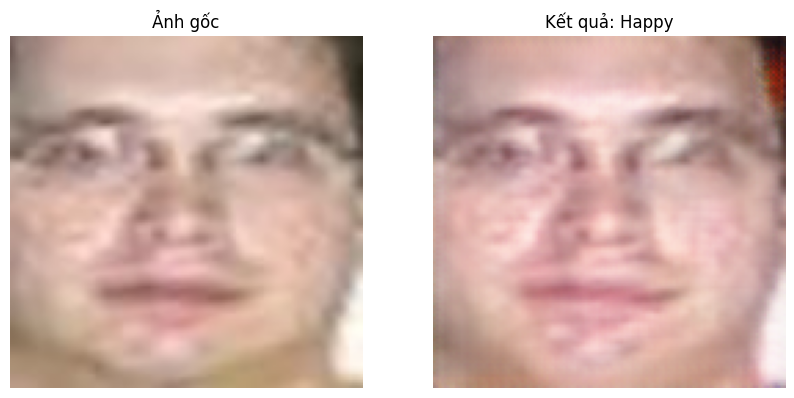

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# --- 1. CẤU HÌNH (SỬA LẠI ĐƯỜNG DẪN CỦA BẠN) ---
# Đường dẫn đến file weights bạn đã train xong (file .h5)
WEIGHTS_PATH = "/kaggle/input/zzzzzz/gen_100.weights.h5"  # <-- Thay đường dẫn file của bạn vào đây
IMAGE_SIZE = 128
C_DIM = 3  # 3 cảm xúc: Neutral, Happy, Sad

# --- 2. ĐỊNH NGHĨA MODEL (BẮT BUỘC PHẢI GIỐNG FILE TRAIN) ---
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(name='scale', shape=input_shape[-1:], initializer=tf.random_normal_initializer(1., 0.02), trainable=True)
        self.offset = self.add_weight(name='offset', shape=input_shape[-1:], initializer='zeros', trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        return self.scale * ((x - mean) * tf.math.rsqrt(variance + self.epsilon)) + self.offset

def res_block(x, filters):
    res = x
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = InstanceNormalization()(x)
    return layers.add([res, x])

def build_generator(image_shape=(128, 128, 3), c_dim=3):
    img_input = layers.Input(shape=image_shape)
    label_input = layers.Input(shape=(c_dim,))
    label_layer = layers.RepeatVector(image_shape[0] * image_shape[1])(label_input)
    label_layer = layers.Reshape((image_shape[0], image_shape[1], c_dim))(label_layer)
    x = layers.concatenate([img_input, label_layer])
    x = layers.Conv2D(64, 7, strides=1, padding='same', use_bias=False)(x); x = InstanceNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False)(x); x = InstanceNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', use_bias=False)(x); x = InstanceNormalization()(x); x = layers.ReLU()(x)
    for _ in range(6): x = res_block(x, 256)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False)(x); x = InstanceNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False)(x); x = InstanceNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(3, 7, strides=1, padding='same', use_bias=False)(x)
    output = layers.Activation('tanh')(x)
    return Model([img_input, label_input], output)

# --- 3. HÀM XỬ LÝ ẢNH & CHẠY TEST ---
def load_and_preprocess_image(image_path):
    # Đọc ảnh bằng OpenCV
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Chuyển sang RGB
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) # Resize về 128x128
    img = (img / 127.5) - 1.0  # Chuẩn hóa về [-1, 1]
    return np.expand_dims(img, axis=0) # Thêm chiều batch -> (1, 128, 128, 3)

def run_demo(image_path, target_emotion_id, generator):
    """
    target_emotion_id:
    0 -> Neutral (Bình thường)
    1 -> Happy (Vui)
    2 -> Sad (Buồn)
    """
    emotion_names = {0: "Neutral", 1: "Happy", 2: "Sad"}
    
    # 1. Xử lý ảnh đầu vào
    input_img = load_and_preprocess_image(image_path)
    if input_img is None:
        print(f"❌ Không tìm thấy ảnh tại: {image_path}")
        return

    # 2. Tạo one-hot label cho cảm xúc đích
    target_label = np.zeros((1, C_DIM))
    target_label[0, target_emotion_id] = 1.0

    # 3. Chạy dự đoán
    generated_img = generator.predict([input_img, target_label], verbose=0)

    # 4. Hiển thị kết quả
    # Denormalize từ [-1, 1] về [0, 1] để hiển thị
    img_show_input = (input_img[0] + 1) / 2.0
    img_show_output = (generated_img[0] + 1) / 2.0

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_show_input)
    plt.title("Ảnh gốc")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_show_output)
    plt.title(f"Kết quả: {emotion_names[target_emotion_id]}")
    plt.axis('off')

    plt.show()

# --- 4. CHẠY CHƯƠNG TRÌNH ---
if __name__ == "__main__":
    # A. Khởi tạo và load weights
    print("🔄 Đang khởi tạo model...")
    generator = build_generator(c_dim=C_DIM)
    
    if os.path.exists(WEIGHTS_PATH):
        try:
            generator.load_weights(WEIGHTS_PATH)
            print("✅ Đã load weights thành công!")
            
            # B. Cấu hình ảnh test
            # Thay đổi đường dẫn ảnh và ID cảm xúc bạn muốn test ở đây
            MY_IMAGE = "/kaggle/input/raf-db-dataset/DATASET/test/7/test_2396_aligned.jpg"  # <-- Đổi thành đường dẫn ảnh của bạn
            TARGET_ID = 1               # 0: Neutral, 1: Happy, 2: Sad
            
            # C. Chạy test
            run_demo(MY_IMAGE, TARGET_ID, generator)
            
        except Exception as e:
            print(f"❌ Lỗi load weights: {e}")
    else:
        print(f"❌ Không tìm thấy file weights tại: {WEIGHTS_PATH}")
        print("Hãy sửa lại biến WEIGHTS_PATH ở đầu file.")